# 0. Import and declaration

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)

Mounted at /content/drive/


In [ ]:
import torch.nn.functional as F
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import random
import os
import zipfile
import numpy as np
import tensorflow as tf  # for data preprocessing
from sklearn.utils import shuffle
import keras
from keras import layers
import nibabel as nib
from scipy import ndimage
%cd /content/drive/MyDrive/ML_Explorers

/content/drive/MyDrive/ML_Explorers


# 1. Data analysis

## Med MNIST 3D

In [ ]:
path_3ds = glob("MNIST/*3d*")

In [ ]:
train_data    = []
val_data      = []
test_data     = []
train_labels  = []
val_labels    = []
test_labels   = []
labels_map    = {}
for idx, path in enumerate(path_3ds):
  data = np.load(path)
  data_train_images = data["train_images"]
  data_val_images   = data['val_images']
  data_test_images = data["test_images"]
  train_data.append(data_train_images)
  train_labels.append(np.ones(len(data_train_images))*idx)
  val_data.append(data_val_images)
  val_labels.append(np.ones(len(data_val_images))*idx)
  test_data.append(data_test_images)
  test_labels.append(np.ones(len(data_test_images))*idx)
  labels_map[path.split("/")[-1].split(".")[0]] = idx
  print("=============================================")

In [ ]:
train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)
val_data = np.concatenate(val_data)
val_labels = np.concatenate(val_labels)
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)
# Shuffle the data and labels
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
val_data, val_labels = shuffle(val_data, val_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(labels_map)

(6910, 28, 28, 28)
(6910,)
(896, 28, 28, 28)
(896,)
(2408, 28, 28, 28)
(2408,)
{'nodulemnist3d': 0, 'vesselmnist3d': 1, 'synapsemnist3d': 2, 'adrenalmnist3d': 3, 'fracturemnist3d': 4, 'organmnist3d': 5}


In [ ]:
def plot_images_with_labels(data, labels, label_map, num_images=10):
    # plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        image = data[i]  # Get the i-th image
        label = labels[i]  # Get the i-th label
        plt.imshow(image[:, :, 0], cmap='gray')  # Plot only one channel (28x28x28, take first slice)
        plt.title(f"{list(label_map.keys())[list(label_map.values()).index(label)]}")
        plt.axis('off')
        plt.subplots_adjust(wspace=2, hspace=0)  # Add more horizontal and vertical space
    plt.show()

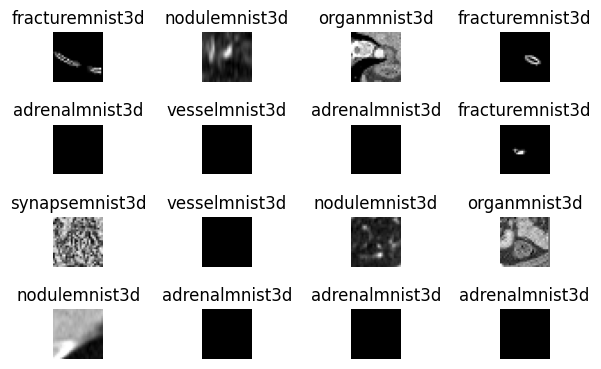

In [ ]:
plot_images_with_labels(train_data, train_labels, labels_map, num_images=16)

## Visualize first sample of each category

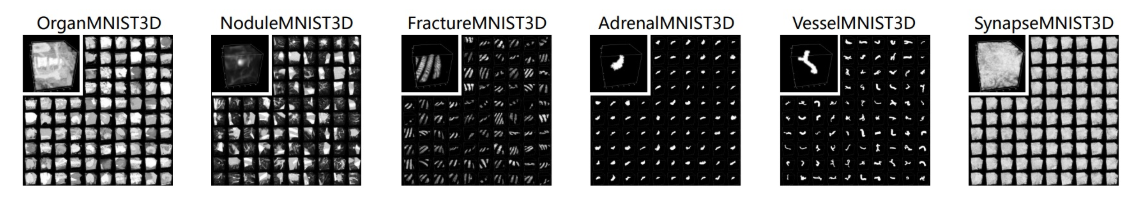

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

Dimension of the CT scan is: (28, 28, 28)


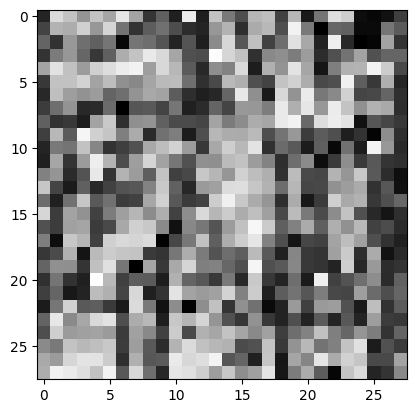

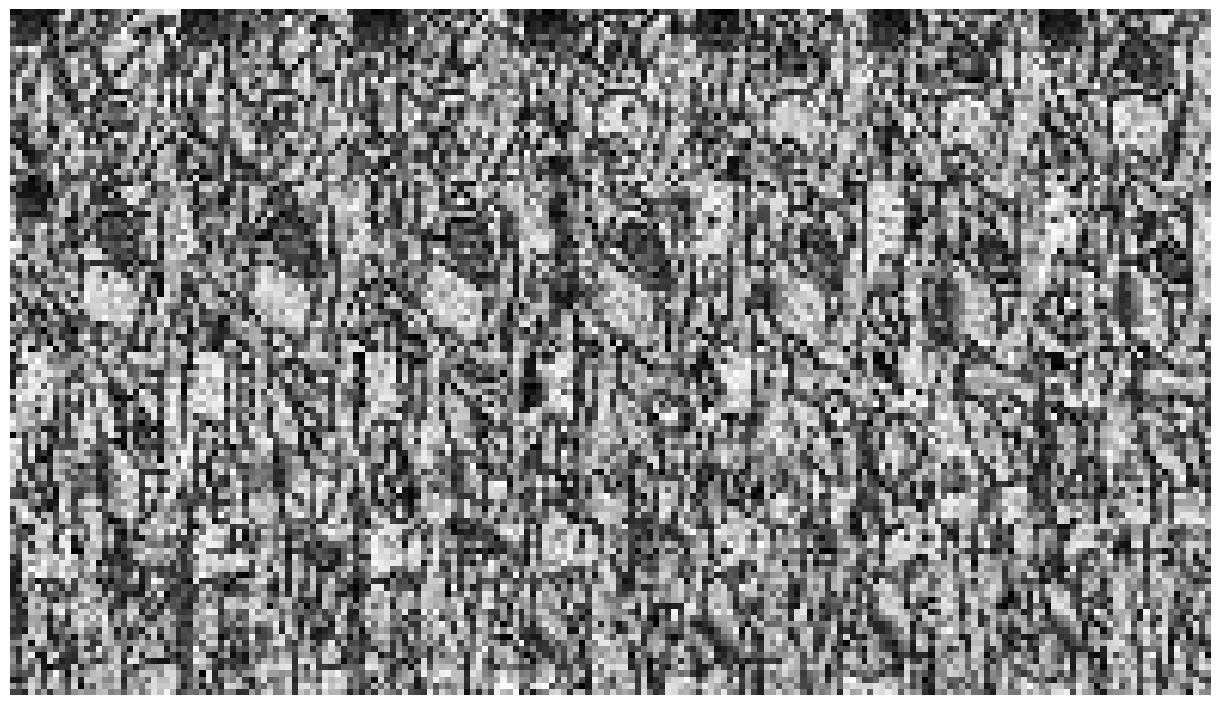

In [ ]:
data = np.load('MNIST/synapsemnist3d.npz')
train_images = data["train_images"]
images = train_images
image  = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")
plot_slices(4, 7, 28, 28, image[:, :, :40])

Dimension of the CT scan is: (28, 28, 28)


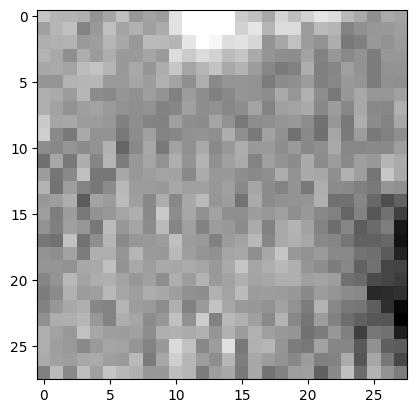

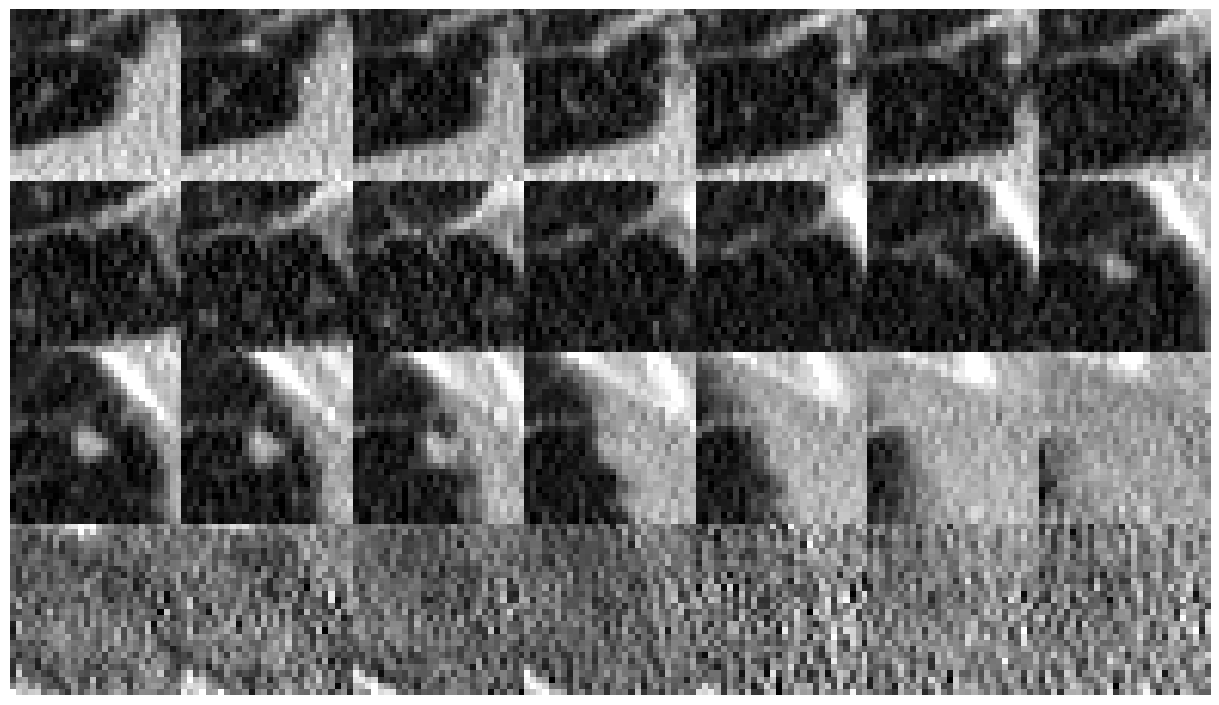

In [ ]:
data = np.load('MNIST/nodulemnist3d.npz')
train_images = data["train_images"]
images = train_images
image  = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")
plot_slices(4, 7, 28, 28, image[:, :, :40])

Dimension of the CT scan is: (28, 28, 28)


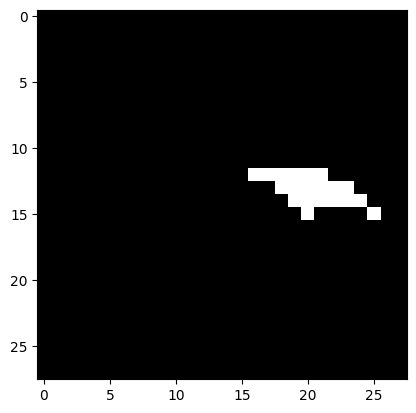

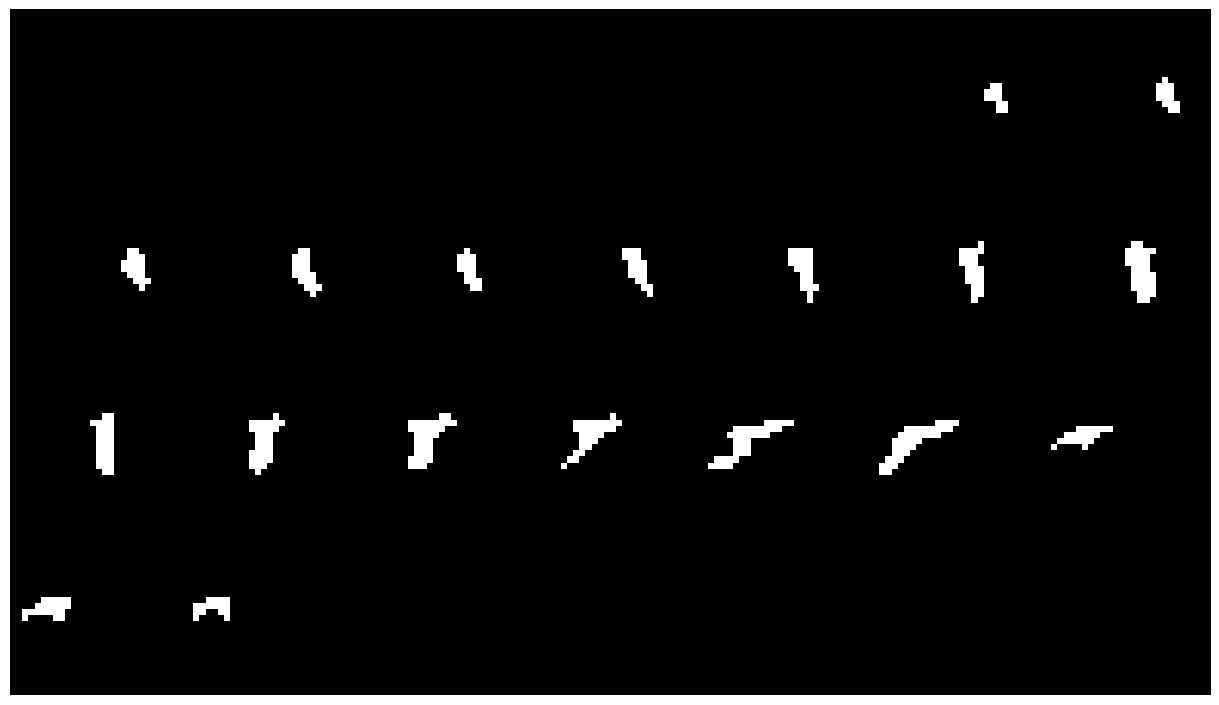

In [ ]:
data = np.load('MNIST/adrenalmnist3d.npz')
train_images = data["train_images"]
images = train_images
image  = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")
plot_slices(4, 7, 28, 28, image[:, :, :40])

Dimension of the CT scan is: (28, 28, 28)


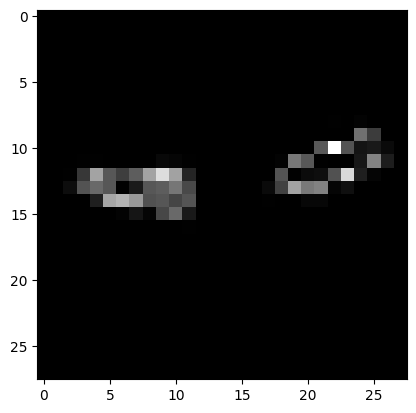

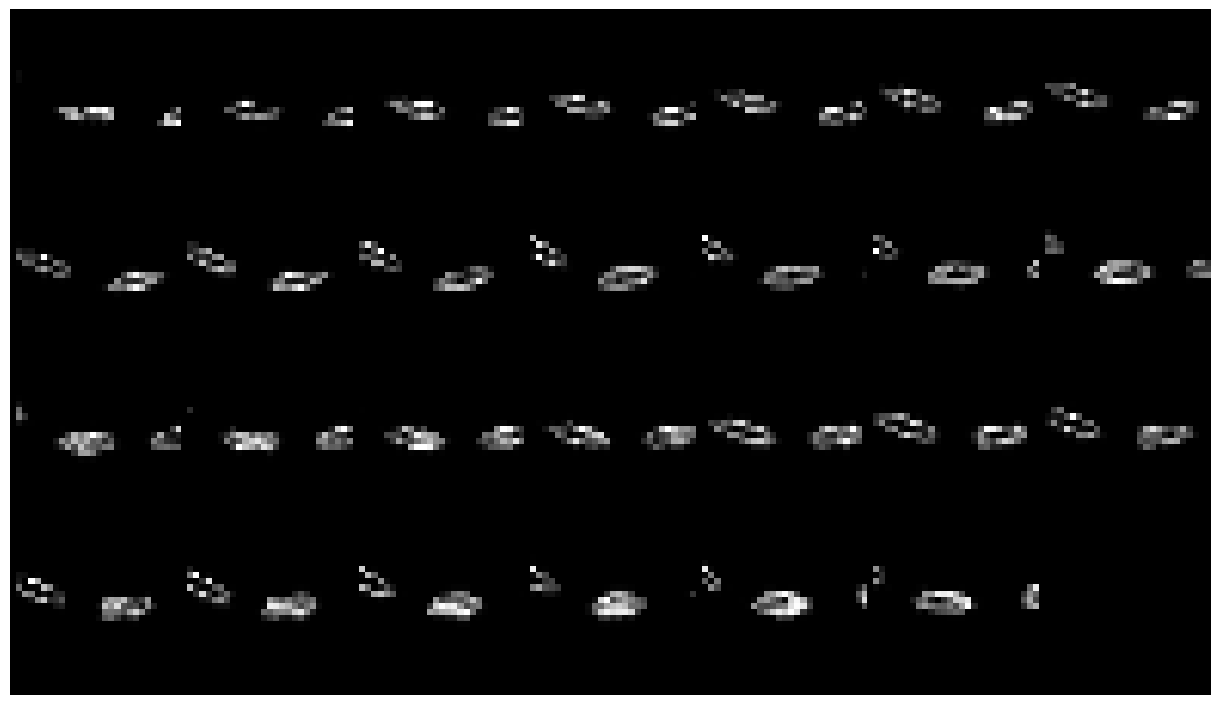

In [ ]:
data = np.load('MNIST/fracturemnist3d.npz')
train_images = data["train_images"]
images = train_images
image  = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")
plot_slices(4, 7, 28, 28, image[:, :, :40])

Dimension of the CT scan is: (28, 28, 28)


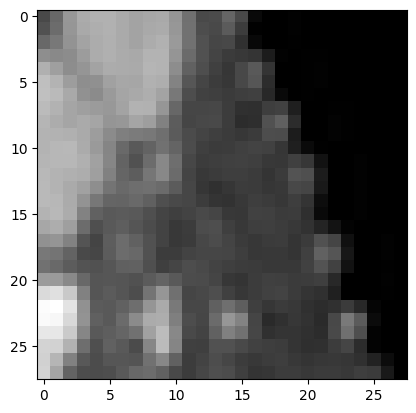

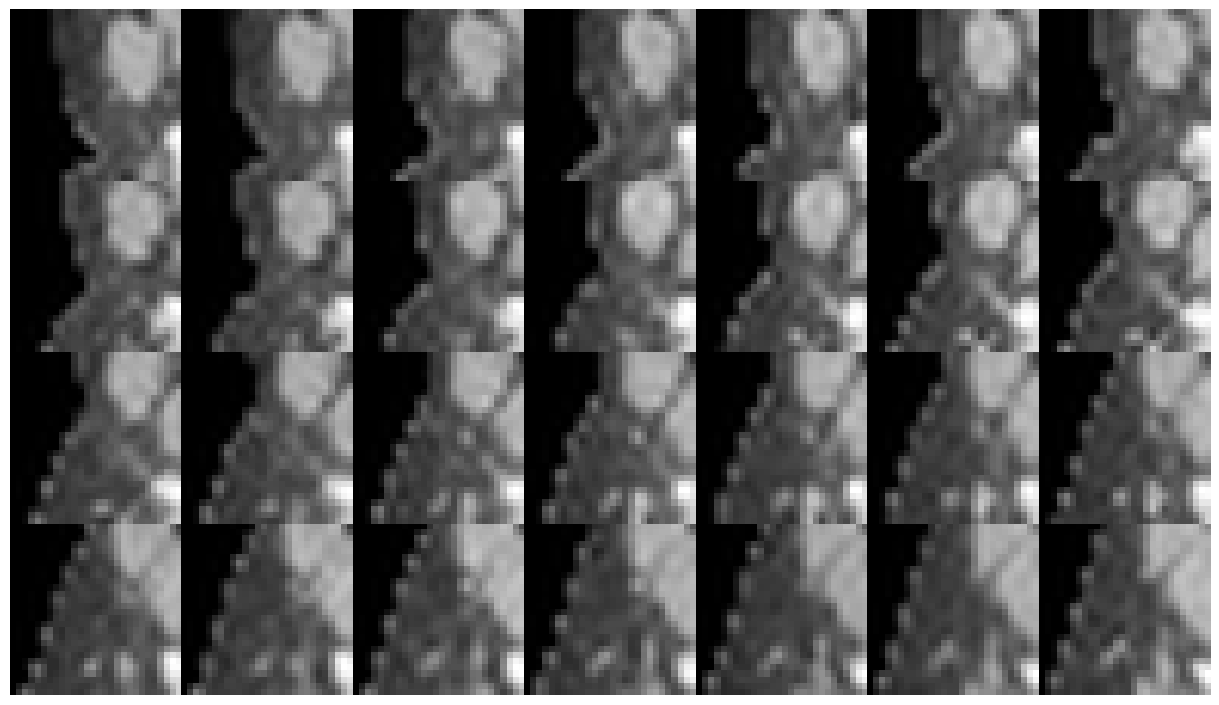

In [ ]:
data = np.load('MNIST/organmnist3d.npz')
train_images = data["train_images"]
images = train_images
image  = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")
plot_slices(4, 7, 28, 28, image[:, :, :40])

## Dataloader

In [ ]:
# Custom Dataset
class Custom3DDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        x = self.data[idx].unsqueeze(0)  # Add channel dimension -> (1, 28, 28, 28)
        y = self.labels[idx]  # Label
        return x, y

In [ ]:
# Custom Dataset
class Custom2DDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]  # Label
        return x, y

# 2. Machine Learning Algorithm

## 2.1. Embedding

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(labels_map)

(6910, 28, 28, 28)
(6910,)
(896, 28, 28, 28)
(896,)
(2408, 28, 28, 28)
(2408,)
{'nodulemnist3d': 0, 'vesselmnist3d': 1, 'synapsemnist3d': 2, 'adrenalmnist3d': 3, 'fracturemnist3d': 4, 'organmnist3d': 5}


### 2.1.1. Flatten image

In [ ]:
flatten_train_data = np.reshape(train_data, (train_data.shape[0], -1))
flatten_val_data = np.reshape(val_data, (val_data.shape[0], -1))
flatten_test_data = np.reshape(test_data, (test_data.shape[0], -1))
print(flatten_train_data.shape)
print(flatten_val_data.shape)
print(flatten_test_data.shape)

(6910, 21952)
(896, 21952)
(2408, 21952)


### 2.1.2. 2D CNN Backbone

In [ ]:
class CNN2D_MLP(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN2D_MLP, self).__init__()

        # CNN Backbone
        self.conv1 = nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # MLP Head (Flatten and Fully Connected Layers)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)  # Output 6 logits

        self.fc1 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512 , 256),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(256 , num_classes),
            nn.ReLU(),
            nn.Dropout(0.5))


    def forward(self, x):
        # CNN Feature Extraction
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # Flatten (batch, 1024, 1, 1) → (batch, 1024)
        x = torch.flatten(x, start_dim=1)

        # MLP Head
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  # (batch_size, 6) logits
        x = F.softmax(x, dim=1)  # Apply softmax across class dimension

        return x
    def get_embedding(self, x):
      # CNN Feature Extraction
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = self.pool(F.relu(self.conv4(x)))
      x = self.pool(F.relu(self.conv5(x)))

      # Flatten (batch, 1024, 1, 1) → (batch, 1024)
      x = torch.flatten(x, start_dim=1)
      return x
# Example usage
batch_size = 8
x = torch.randn(batch_size, 28, 28, 28)  # (batch_size, 28, 28, 28)
x = x.permute(0, 3, 1, 2)  # Change to (batch_size, channels, height, width)

model = CNN2D_MLP(num_classes=6)
output = model(x)
embedding = model.get_embedding(x)
print(output.shape)  # Expected output: (batch_size, 6)
print(embedding.shape)  # Expected output: (batch_size, 1024)

torch.Size([8, 6])
torch.Size([8, 1024])


### 2.1.3. 3D CNN Backbone

In [ ]:
class CNN3D_MLP(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN3D_MLP, self).__init__()

        # 3D CNN Backbone
        self.group1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2)))

        self.group2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2)))

        self.group3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2)))

        self.group4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2)))

        self.group5 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))

        # MLP Head (Flatten and Fully Connected Layers)
        self.fc1 = nn.Linear(11776, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)  # Output 6 logits

    def forward(self, x):
        # 3D CNN Feature Extraction
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
    def embedding(self,x):
        # CNN Feature Extraction
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x
# Example usage
batch_size = 8
x = torch.randn(8, 28, 28, 28)  # (batch_size, 28, 28, 28)
x = x.unsqueeze(1)  # Add a channel dimension → (batch_size, 28, 28, 28, 28)

model = CNN3D_MLP(num_classes=6)
output = model(x)


print(output.shape)  # Expected output: (batch_size, 6)
print(embedding.shape)

torch.Size([8, 6])
torch.Size([8, 1024])


### 2.1.4. Embedding training

2D CNN MLP

Epoch 1/10 | Train Loss: 1.7951 | Val Loss: 1.7869
✅ Best Model Saved!
Epoch 2/10 | Train Loss: 1.7508 | Val Loss: 1.7370
✅ Best Model Saved!
Epoch 3/10 | Train Loss: 1.7844 | Val Loss: 1.7918
Epoch 4/10 | Train Loss: 1.7920 | Val Loss: 1.7918
Epoch 5/10 | Train Loss: 1.7931 | Val Loss: 1.7918
Epoch 6/10 | Train Loss: 1.7976 | Val Loss: 1.7918
Epoch 7/10 | Train Loss: 1.7931 | Val Loss: 1.7918
Epoch 8/10 | Train Loss: 1.7919 | Val Loss: 1.7918
Epoch 9/10 | Train Loss: 1.7927 | Val Loss: 1.7918
Epoch 10/10 | Train Loss: 1.7928 | Val Loss: 1.7918
🎉 Training Complete!


<ipython-input-33-cfae7b870b07>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_2D_CNN.pth"))


🧪 Test Loss: 1.7185 | Test Accuracy: 25.66%


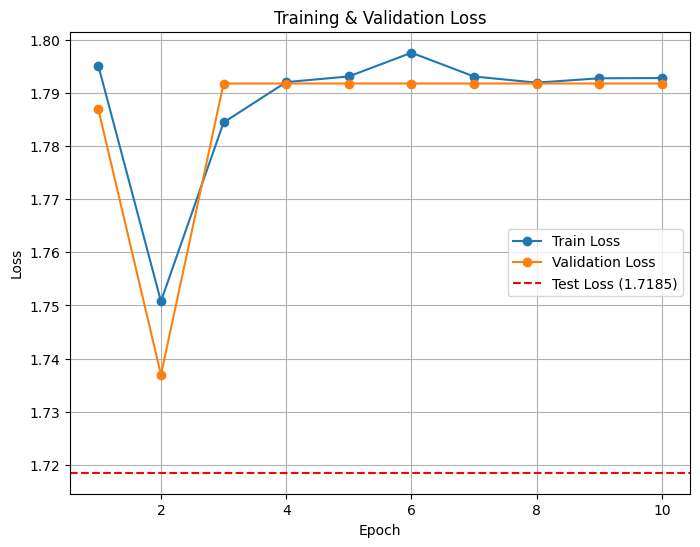

In [ ]:
train_dataset = Custom2DDataset(train_data, train_labels)
val_dataset = Custom2DDataset(val_data, val_labels)
test_dataset = Custom2DDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# ✅ Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2D_MLP(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ✅ Training Loop
num_epochs = 10
train_losses, val_losses = [], []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ✅ Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ✅ Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_2D_CNN.pth")
        print("✅ Best Model Saved!")

print("🎉 Training Complete!")

# ✅ Load Best Model for Testing
model.load_state_dict(torch.load("best_model_2D_CNN.pth"))
model.eval()

# ✅ Testing Loop
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute Accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"🧪 Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

# ✅ Plot Training, Validation & Test Loss
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.axhline(avg_test_loss, linestyle="--", color="red", label=f"Test Loss ({avg_test_loss:.4f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

3D CNN MLP

Epoch 1/10 | Train Loss: 8.5612 | Val Loss: 8.7411
✅ Best Model Saved!
Epoch 2/10 | Train Loss: 1.2602 | Val Loss: 2.6758
✅ Best Model Saved!
Epoch 3/10 | Train Loss: 0.8873 | Val Loss: 0.8982
✅ Best Model Saved!
Epoch 4/10 | Train Loss: 0.7029 | Val Loss: 0.7389
✅ Best Model Saved!
Epoch 5/10 | Train Loss: 0.6407 | Val Loss: 0.7012
✅ Best Model Saved!
Epoch 6/10 | Train Loss: 0.5725 | Val Loss: 0.7652
Epoch 7/10 | Train Loss: 0.4693 | Val Loss: 0.4306
✅ Best Model Saved!
Epoch 8/10 | Train Loss: 0.3469 | Val Loss: 0.2854
✅ Best Model Saved!
Epoch 9/10 | Train Loss: 0.2522 | Val Loss: 0.2378
✅ Best Model Saved!
Epoch 10/10 | Train Loss: 0.1926 | Val Loss: 0.3906
🎉 Training Complete!


<ipython-input-23-61d997a5beae>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


🧪 Test Loss: 0.5810 | Test Accuracy: 83.01%


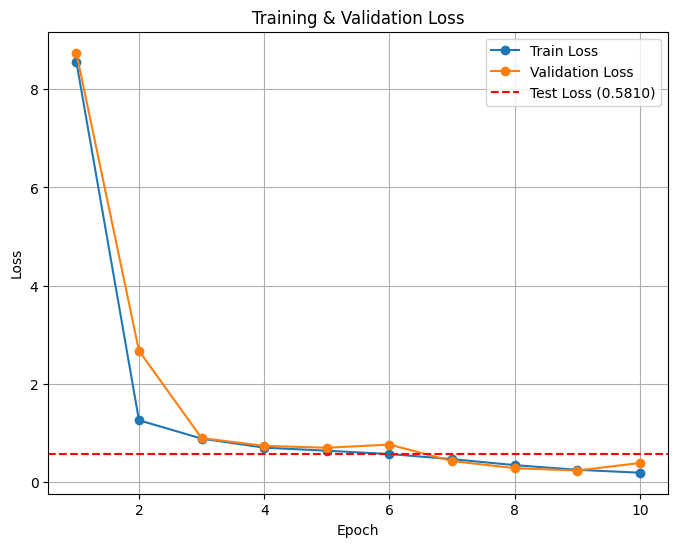

In [ ]:
# Create Dataset & DataLoader
train_dataset = Custom3DDataset(train_data, train_labels)
val_dataset = Custom3DDataset(val_data, val_labels)
test_dataset = Custom3DDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN3D_MLP(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
train_losses, val_losses = [], []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_3D_CNN.pth")
        print("✅ Best Model Saved!")

print("🎉 Training Complete!")

# Load Best Model for Testing
model.load_state_dict(torch.load("best_model_3D_CNN.pth"))
model.eval()

# Testing Loop
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute Accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"🧪 Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

# Plot Training, Validation & Test Loss
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.axhline(avg_test_loss, linestyle="--", color="red", label=f"Test Loss ({avg_test_loss:.4f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

## 2.2 Classifier

## 2.3 Evaluation|